In [125]:
import pandas as pd
import numpy as np
import os
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.cm as cm
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import nltk
import warnings
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import time
import gensim.corpora as corpora
from gensim.models import HdpModel
from gensim.models import CoherenceModel
from gensim.models import LdaModel
import pickle 
import re
                                                                                                                                                                                                                                                                                                                                                                                  

In [2]:
os.chdir('/Users/amaltom/downloads')
os.getcwd()

'/Users/amaltom/Downloads'

Reading Relevant Files

In [4]:
FBH_Job_Data = pd.read_csv('JobPostings.csv')
Education_Job_Data = pd.read_csv('JobPostingsEdu.csv')

In [9]:
FBH_Job_Data.head()

Link  \
0  https://stlouis.craigslist.org/fbh/d/saint-lou...   
1  https://chicago.craigslist.org/chc/fbh/d/india...   
2  https://lansing.craigslist.org/fbh/d/bath-shop...   
3  https://bn.craigslist.org/fbh/d/south-bend-exe...   
4  https://stlouis.craigslist.org/fbh/d/chesterfi...   

                                       Posting Title Location Category  \
0                               Prep and Event Cooks  stlouis      fbh   
1  DIRECTOR, DINING SERVICES - K12 - Pike Townshi...  chicago      fbh   
2          Shop and Deliver - No Experience Required  lansing      fbh   
3  EXECUTIVE CHEF - K12 - Career Academy - South ...       bn      fbh   
4  RESIDENT DISTRICT MANAGER - K12 - Parkway Scho...  stlouis      fbh   

                                        Posting Text  
0  QR Code Link to This Post   Need of experience...  
1  QR Code Link to This Post   Salary:   Chartwel...  
2  QR Code Link to This Post      Shop and delive...  
3  QR Code Link to This Post   Salary:   Chartwel...  
4  QR Code Link to This Post   Salary:   Chartwel...

In [15]:
Education_Job_Data.head()

Link  \
0  https://boone.craigslist.org/edu/d/boone-nurse...   
1  https://asheville.craigslist.org/edu/d/candler...   
2  https://albanyga.craigslist.org/edu/d/albany-m...   
3  https://atlanta.craigslist.org/eat/edu/d/pine-...   
4  https://atlanta.craigslist.org/sat/edu/d/atlan...   

                                       Posting Title   Location Category  \
0               nursery staff needed at app ski mtn.      boone      edu   
1        challenge island steam enrichment franchise  asheville      edu   
2  making a difference in the black community. pa...   albanyga      edu   
3                                  childcare teacher    atlanta      edu   
4  experience childcare teachers & van drivers ne...    atlanta      edu   

                                        Posting Text  
0  qr code link to this post   app ski mtn is cur...  
1  qr code link to this post   challenge island i...  
2  qr code link to this post   we are a black-own...  
3  qr code link to this post   early childhood ed...  
4  qr code link to this post   childcare teachers...

### DATA CLEANING

In [10]:
print(Education_Job_Data.shape)
print(FBH_Job_Data.shape)

(683, 5)
(1464, 5)


In [13]:
Education_Job_Data = Education_Job_Data.apply(lambda x: x.astype(str).str.lower()).drop_duplicates(subset=['Posting Text'], keep ='first')
FBH_Job_Data = FBH_Job_Data.apply(lambda x: x.astype(str).str.lower()).drop_duplicates(subset=['Posting Text'], keep = 'first')

In [14]:
print(Education_Job_Data.shape)
print(FBH_Job_Data.shape)

(649, 5)
(1459, 5)


#### Education Job Data - Cleaning

In [19]:
Education_Job_Data['tokenized description'] = [nltk.word_tokenize(x) for x in Education_Job_Data['Posting Text']]

In [25]:
review_collection = []
for line in Education_Job_Data['tokenized description']:
    single_review = []
    for word in line:
        reg_sub = re.sub(r'[^\w\s]','',word)
        single_review.append(reg_sub)
    review_collection.append(single_review)

In [27]:
Education_Job_Data['cleaned description'] = review_collection

In [29]:
stopwords_list = stopwords.words('english')

words_to_add = ['qr','code','link','to','this','post','click','here','http','https']
stopwords_list = stopwords_list + words_to_add

In [32]:
stop_words_removed_description=[]
for l in Education_Job_Data['cleaned description']:
    stop_words_removed=[]
    stop_words_removed=[word for word in l if word.lower() not in stopwords_list if word.isalpha()]
    stop_words_removed_description.append(stop_words_removed)

Education_Job_Data['stop_words_removed description'] = stop_words_removed_description

In [35]:
#removing single letters between reviews since they do not give us any information

single_letter_removed_description=[]
for l in Education_Job_Data['stop_words_removed description']:
    single_letter_removed=[] 
    single_letter_removed=[word for word in l if len(word)!=1]
    single_letter_removed_description.append(single_letter_removed)
Education_Job_Data['single_letter_removed_description'] = single_letter_removed_description

In [36]:
lemmatizer = WordNetLemmatizer()
lemmatized_description=[]
for l in Education_Job_Data['single_letter_removed_description']:
    lemmatized_words=[]
    lemmatized_words=[lemmatizer.lemmatize(word.lower()) if word.isalpha() else word.lower() for word in l]
    lemmatized_description.append(lemmatized_words)

Education_Job_Data['lemmatized description'] = lemmatized_description

In [40]:
Education_Job_Data['final cleaned posting text'] = [' '.join(word) for word in Education_Job_Data['lemmatized description']]

#### FBH Job Data - Cleaning

In [42]:
FBH_Job_Data['tokenized description'] = [nltk.word_tokenize(x) for x in FBH_Job_Data['Posting Text']]

In [46]:
review_collection = []
for line in FBH_Job_Data['tokenized description']:
    single_review = []
    for word in line:
        reg_sub = re.sub(r'[^\w\s]','',word)
        single_review.append(reg_sub)
    review_collection.append(single_review)

In [47]:
FBH_Job_Data['cleaned description'] = review_collection

In [48]:
stopwords_list = stopwords.words('english')

words_to_add = ['qr','code','link','to','this','post','click','here','http','https']
stopwords_list = stopwords_list + words_to_add

In [49]:
stop_words_removed_description=[]
for l in FBH_Job_Data['cleaned description']:
    stop_words_removed=[]
    stop_words_removed=[word for word in l if word.lower() not in stopwords_list if word.isalpha()]
    stop_words_removed_description.append(stop_words_removed)

FBH_Job_Data['stop_words_removed description'] = stop_words_removed_description

In [50]:
#removing single letters between reviews since they do not give us any information

single_letter_removed_description=[]
for l in FBH_Job_Data['stop_words_removed description']:
    single_letter_removed=[] 
    single_letter_removed=[word for word in l if len(word)!=1]
    single_letter_removed_description.append(single_letter_removed)
FBH_Job_Data['single_letter_removed_description'] = single_letter_removed_description

In [51]:
lemmatizer = WordNetLemmatizer()
lemmatized_description=[]
for l in FBH_Job_Data['single_letter_removed_description']:
    lemmatized_words=[]
    lemmatized_words=[lemmatizer.lemmatize(word.lower()) if word.isalpha() else word.lower() for word in l]
    lemmatized_description.append(lemmatized_words)

FBH_Job_Data['lemmatized description'] = lemmatized_description

In [52]:
FBH_Job_Data['final cleaned posting text'] = [' '.join(word) for word in FBH_Job_Data['lemmatized description']]

### MODEL DEVELOPMENT

#### EDUCATION CATEGORY

In [55]:
#### Getting TFIDF for the Education category

In [56]:
Education_Data = list(Education_Job_Data['final cleaned posting text'])

In [58]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=3)

In [60]:
vectorizer.fit(Education_Data)
print(vectorizer.vocabulary_)

{'app': 430, 'ski': 7882, 'currently': 2079, 'hiring': 3966, 'nursery': 5651, 'staff': 8061, 'season': 7627, 'duty': 2563, 'include': 4205, 'oversight': 5918, 'program': 6661, 'child': 1333, 'age': 284, 'operating': 5794, 'apply': 458, 'person': 6180, 'main': 5029, 'office': 5715, 'day': 2144, 'week': 9316, 'currently hiring': 2082, 'duty include': 2568, 'include oversight': 4214, 'program child': 6665, 'child age': 1338, 'apply person': 469, 'main office': 5030, 'day week': 2172, 'challenge': 1271, 'island': 4498, 'looking': 4932, 'add': 188, 'across': 137, 'country': 1940, 'teacher': 8551, 'love': 4980, 'kid': 4606, 'might': 5293, 'right': 7353, 'entrepreneur': 2939, 'magazine': 5024, 'named': 5490, 'one': 5738, 'top': 8881, 'world': 9587, 'run': 7424, 'inschool': 4350, 'field': 3330, 'trip': 8977, 'school': 7532, 'summer': 8397, 'camp': 1070, 'family': 3247, 'night': 5595, 'email': 2744, 'text': 8745, 'get': 3662, 'information': 4308, 'looking add': 4933, 'across country': 140, 'lov

In [61]:
Tfidf_education = vectorizer.transform(Education_Data)

In [65]:
kmeans = KMeans(n_clusters=8).fit(Tfidf_education)

#### Getting Clusters for Education data

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


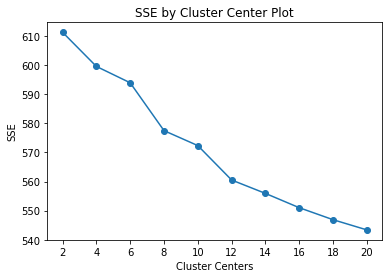

In [64]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(Tfidf_education, 20)


In [66]:
clusters = MiniBatchKMeans(n_clusters=8, init_size=1024, batch_size=2048, random_state=20).fit_predict(Tfidf_education)

In [304]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    list1 = []
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
        list1.append(format(i))
        list1.append([labels[t] for t in np.argsort(r)[-n_terms:]])
    return(list1)
    
        
get_top_keywords(Tfidf_education, clusters, vectorizer.get_feature_names(), 40)


Cluster 0
working,classroom,paid,day care,part time,work,teacher must,en,hire,childcare,schedule,must,toddler,part,school,call,fulltime,assistant teacher,full time,maestra,position,teacher assistant,full,experience,child,hour,care,para,time,looking,substitute teacher,day,preschool teacher,job,de,assistant,preschool,substitute,daycare,teacher

Cluster 1
customer,per year,fun,time,phone interview,great,within,management,free,income,money,best,year,figure,six figure,course,passionate,difference,grow,hand,make difference,drive,average,know,give,allows,side,scholarship,people,six,notforprofit,significantly,ex,per child,want,program,per,make,sale,community

Cluster 2
grade,provide,degree,year,test,high,individual,working,academic,director,special,must,college,staff,job,training,opportunity,please,learning,chess,candidate,ability,support,service,class,math,required,hour,teaching,teacher,position,program,skill,experience,education,work,tutor,tutoring,school,student

Cluster 3
apply ramapocamp

['0',
 ['working',
  'classroom',
  'paid',
  'day care',
  'part time',
  'work',
  'teacher must',
  'en',
  'hire',
  'childcare',
  'schedule',
  'must',
  'toddler',
  'part',
  'school',
  'call',
  'fulltime',
  'assistant teacher',
  'full time',
  'maestra',
  'position',
  'teacher assistant',
  'full',
  'experience',
  'child',
  'hour',
  'care',
  'para',
  'time',
  'looking',
  'substitute teacher',
  'day',
  'preschool teacher',
  'job',
  'de',
  'assistant',
  'preschool',
  'substitute',
  'daycare',
  'teacher'],
 '1',
 ['customer',
  'per year',
  'fun',
  'time',
  'phone interview',
  'great',
  'within',
  'management',
  'free',
  'income',
  'money',
  'best',
  'year',
  'figure',
  'six figure',
  'course',
  'passionate',
  'difference',
  'grow',
  'hand',
  'make difference',
  'drive',
  'average',
  'know',
  'give',
  'allows',
  'side',
  'scholarship',
  'people',
  'six',
  'notforprofit',
  'significantly',
  'ex',
  'per child',
  'want',
  'pro

In [75]:
Education_Job_Data['Clusters'] = clusters

In [85]:
X_train,X_test,y_train,y_test = train_test_split(Education_Job_Data['Posting Text'],Education_Job_Data['Clusters'], random_state = 0)
X_train_Tfidf = vectorizer.transform(X_train)
X_test_Tfidf = vectorizer.transform(X_test)

In [86]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0)
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

In [87]:
features = X_train_Tfidf
labels = y_train

In [88]:
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

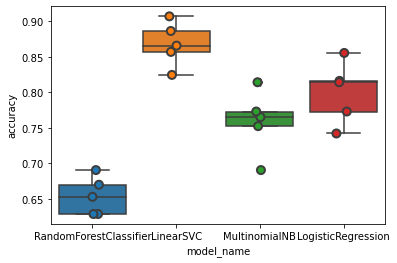

model_name
LinearSVC                 0.868336
LogisticRegression        0.800379
MultinomialNB             0.759247
RandomForestClassifier    0.654324
Name: accuracy, dtype: float64

In [89]:
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()
# Accuracy score
cv_df.groupby('model_name').accuracy.mean()

In [92]:
features = X_train_Tfidf
labels = y_train

model = LinearSVC()

model.fit(X_train_Tfidf, y_train)
y_pred = model.predict(X_test_Tfidf)

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)

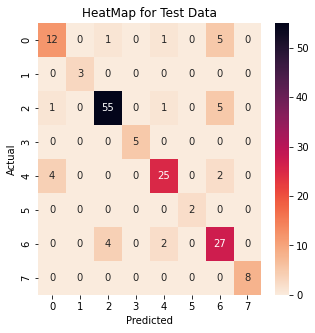

In [95]:
fig, ax = plt.subplots(figsize=(5,5))
#sns.heatmap(conf_mat, annot=True, fmt='d',
#            xticklabels=Education_Cleaned.Classification_category, yticklabels=Education_Cleaned.Classification_category)

sns.heatmap(conf_mat, annot=True, fmt='d',
           cmap = sns.cm.rocket_r)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('HeatMap for Test Data')
plt.show()

#### Model Accuracy

In [102]:
print(metrics.accuracy_score(y_test, y_pred))

0.8404907975460123


#### FBH CATEGORY

In [103]:
FBH_Data = list(FBH_Job_Data['final cleaned posting text'])

In [107]:
vectorizer2 = TfidfVectorizer(ngram_range=(1, 2), min_df=3)

In [108]:
vectorizer2.fit(FBH_Data)
print(vectorizer2.vocabulary_)

{'need': 10463, 'experienced': 5537, 'prep': 12256, 'cook': 3154, 'afternoon': 355, 'evening': 5169, 'event': 5180, 'need experienced': 10475, 'experienced prep': 5550, 'prep cook': 12258, 'need cook': 10469, 'afternoon evening': 356, 'salary': 14075, 'chartwells': 2215, 'goal': 6631, 'make': 9462, 'sure': 15818, 'student': 15640, 'leave': 8802, 'cafeteria': 1866, 'happier': 7097, 'healthier': 7155, 'came': 1921, 'serving': 14626, 'food': 6019, 'kid': 8471, 'love': 9295, 'eat': 4512, 'creating': 3399, 'custom': 3555, 'dining': 4089, 'program': 12623, 'associate': 912, 'school': 14269, 'ranging': 13038, 'large': 8659, 'public': 12849, 'institution': 8056, 'small': 15009, 'charter': 2213, 'private': 12449, 'built': 1760, 'decade': 3770, 'education': 4530, 'operational': 10993, 'experience': 5406, 'driven': 4387, 'top': 16541, 'culinary': 3489, 'nutrition': 10712, 'wellness': 17494, 'sustainability': 15842, 'talent': 15940, 'information': 7969, 'visit': 17193, 'summarythe': 15728, 'direct

In [109]:
Tfidf_FBH = vectorizer2.transform(FBH_Data)

In [110]:
kmeans = KMeans(n_clusters=4).fit(Tfidf_FBH)

#### Getting Clusters for Education data

Fit 2 clusters
Fit 4 clusters
Fit 6 clusters
Fit 8 clusters
Fit 10 clusters
Fit 12 clusters
Fit 14 clusters
Fit 16 clusters
Fit 18 clusters
Fit 20 clusters


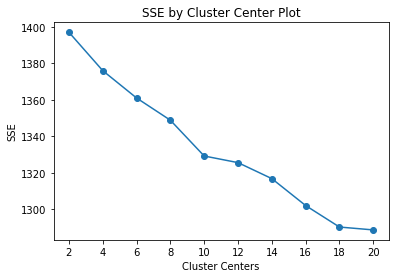

In [111]:
def find_optimal_clusters(data, max_k):
    iters = range(2, max_k+1, 2)
    
    sse = []
    for k in iters:
        sse.append(MiniBatchKMeans(n_clusters=k, init_size=1024, batch_size=2048, random_state=20).fit(data).inertia_)
        print('Fit {} clusters'.format(k))
        
    f, ax = plt.subplots(1, 1)
    ax.plot(iters, sse, marker='o')
    ax.set_xlabel('Cluster Centers')
    ax.set_xticks(iters)
    ax.set_xticklabels(iters)
    ax.set_ylabel('SSE')
    ax.set_title('SSE by Cluster Center Plot')
    
find_optimal_clusters(Tfidf_FBH, 20)


In [112]:
clusters_FBH = MiniBatchKMeans(n_clusters=10, init_size=1024, batch_size=2048, random_state=20).fit_predict(Tfidf_FBH)

In [300]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))
            
get_top_keywords(Tfidf_FBH, clusters_FBH, vectorizer2.get_feature_names(), 40)


Cluster 0
work,italian restaurant,family owned,busy,restaurant hiring,full time,number email,able lift,immediate start,fried,pay,tip,start,plus tip,apply interested,open,neighborhood,hiring,full,back,cook,looking,time,seeking experienced,seeking,resume,number,bartender,plus,phone,email,respond resume,experienced,please respond,phone number,respond,please,grill,bar grill,bar

Cluster 1
order,hospitality,position,knowledge,opportunity,item,apply,working,must able,duty,menu,required,employee,team member,cook,quality,management,job,responsibility,ensure,maintain,staff,environment,time,standard,manager,member,able,must,skill,ability,customer,experience,kitchen,restaurant,service,guest,work,team,food

Cluster 2
make,per,email,opportunity,bartender,open,fun,join,service,guest,plus,job,customer,part,apply,interview,available,night,week,resume,food,tip,weekend,hiring,call,day,pay,server,time,position,restaurant,please,must,great,shift,team,hour,experience,work,looking

Cluster 3
parttime hour,

In [116]:
FBH_Job_Data['Clusters'] = clusters_FBH

In [342]:
X_train,X_test,y_train,y_test = train_test_split(FBH_Job_Data['Posting Text'],FBH_Job_Data['Clusters'], random_state = 0)
X_train_Tfidf = vectorizer2.transform(X_train)
X_test_Tfidf = vectorizer2.transform(X_test)

In [343]:
models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0)
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

In [344]:
features = X_train_Tfidf
labels = y_train

In [345]:
entries = []
for model in models:
    model_name = model.__class__.__name__
    accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

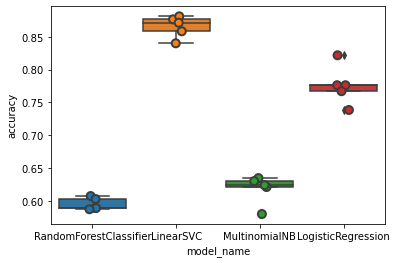

model_name
LinearSVC                 0.865636
LogisticRegression        0.776017
MultinomialNB             0.617921
RandomForestClassifier    0.595057
Name: accuracy, dtype: float64

In [346]:
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()
# Accuracy score
cv_df.groupby('model_name').accuracy.mean()

In [347]:
features = X_train_Tfidf
labels = y_train

model = LinearSVC()

model.fit(X_train_Tfidf, y_train)
y_pred = model.predict(X_test_Tfidf)

from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred)

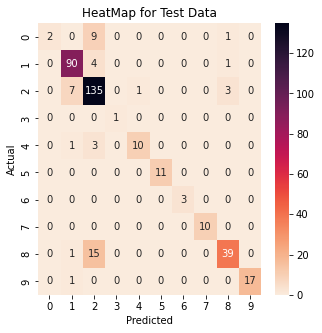

In [348]:
fig, ax = plt.subplots(figsize=(5,5))
#sns.heatmap(conf_mat, annot=True, fmt='d',
#            xticklabels=Education_Cleaned.Classification_category, yticklabels=Education_Cleaned.Classification_category)

sns.heatmap(conf_mat, annot=True, fmt='d',
           cmap = sns.cm.rocket_r)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('HeatMap for Test Data')
plt.show()

In [349]:
print(metrics.accuracy_score(y_test, y_pred))

0.8712328767123287


#### LDA topic modelling for Education Category

In [126]:
##Finding the length of job descriptions in Education Category 

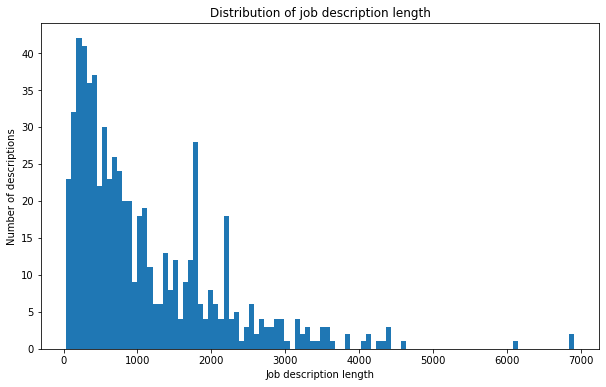

In [131]:
plt.figure(figsize=(10,6))

Education_Data_size = [len(x) for x in Education_Job_Data['final cleaned posting text']]
plt.hist(Education_Data_size, bins=100)
plt.title('Distribution of job description length')
plt.ylabel('Number of descriptions')
plt.xlabel('Job description length')
plt.show()

In [134]:
Education_Job_Data.columns

Index(['Link', 'Posting Title', 'Location', 'Category', 'Posting Text',
       'tokenized description', 'cleaned description',
       'stop_words_removed description', 'single_letter_removed_description',
       'lemmatized description', 'final cleaned posting text', 'Clusters'],
      dtype='object')

In [135]:
#Transforming data to prepare for the input to lda model

lemmatized_description_lol_edu = list(Education_Job_Data['lemmatized description'])
#Dictionary
id2word = corpora.Dictionary(lemmatized_description_lol_edu)
texts = lemmatized_description_lol_edu
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 2), (11, 2), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 3), (19, 1), (20, 1)]]


In [140]:
#Building a baseline LDA model : starting with 5 topics for now

lda_model = LdaModel(corpus=corpus,
                     id2word=id2word,
                     num_topics=8, 
                     random_state=100,
                     chunksize=100,
                     passes=20)

In [141]:
#Top 10 words for each topic

for idx, topic in lda_model.print_topics():
   print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.022*"community" + 0.016*"make" + 0.013*"program" + 0.012*"per" + 0.009*"year" + 0.009*"time" + 0.008*"child" + 0.008*"people" + 0.008*"scholarship" + 0.007*"drive"
Topic: 1 
Words: 0.016*"student" + 0.012*"please" + 0.012*"hour" + 0.011*"work" + 0.009*"tutor" + 0.009*"looking" + 0.009*"experience" + 0.008*"teaching" + 0.008*"school" + 0.008*"time"
Topic: 2 
Words: 0.025*"camp" + 0.014*"camper" + 0.013*"day" + 0.013*"summer" + 0.013*"chess" + 0.010*"staff" + 0.010*"ramapo" + 0.010*"program" + 0.009*"de" + 0.007*"teacher"
Topic: 3 
Words: 0.017*"sale" + 0.014*"status" + 0.012*"disability" + 0.012*"race" + 0.011*"origin" + 0.010*"customer" + 0.010*"employer" + 0.010*"national" + 0.009*"employment" + 0.009*"sexual"
Topic: 4 
Words: 0.040*"music" + 0.033*"student" + 0.025*"lesson" + 0.023*"teaching" + 0.020*"school" + 0.019*"teacher" + 0.016*"substitute" + 0.014*"rock" + 0.011*"teach" + 0.009*"district"
Topic: 5 
Words: 0.066*"youth" + 0.043*"dream" + 0.013*"harlem" + 0.0

In [199]:
lda_top10_data = lda_model.print_topics(10, num_words=5)[:10]

In [225]:
k = lda_top10_data[0][1]
my_list = re.findall(r'"([^"]*)"',k)
print(my_list)

['community', 'make', 'program', 'per', 'year']


In [178]:
train_vecs = []
for i in range(len(Education_Data)):
    top_topics = (
        lda_model.get_document_topics(corpus[i],
                                      minimum_probability=0.0))
    topic_vec = [top_topics[i][1] for i in range(7)]
    train_vecs.append(topic_vec)

In [181]:
index_list = []
for i in train_vecs:
    ind = np.argmax(i)
    index_list.append(ind)

In [293]:
overall_topics = []
overall_missed_words = []
for i in range(len(Education_Job_Data['final cleaned posting text'])):
    try:
        missing_words = []
        print(Education_Job_Data['final cleaned posting text'][i])
        print('The recommended topic is ', lda_model.print_topics(10, num_words=10)[:10][index_list[i]])
        for j in re.findall(r'"([^"]*)"',lda_top10_data[index_list[i]][1]):
            if j not in list(Education_Job_Data['lemmatized description'][i]):
                print(j, 'is not in the review despite being in the top recommended topic, do you want to reconsider?')
                missing_words.append(j)
        overall_topics.append(lda_model.print_topics(10, num_words=10)[:10][index_list[i]])
        overall_missed_words.append(missing_words)
    except:
        overall_topics.append('None')
        overall_missed_words.append('None')
        continue
Education_Job_Data['Topics_assigned'] = overall_topics
Education_Job_Data['Missing_words'] =  overall_missed_words

app ski mtn currently hiring nursery staff ski season duty include oversight nursery program child age operating apply person app ski mtn main office day week
The recommended topic is  (1, '0.016*"student" + 0.012*"please" + 0.012*"hour" + 0.011*"work" + 0.009*"tutor" + 0.009*"looking" + 0.009*"experience" + 0.008*"teaching" + 0.008*"school" + 0.008*"time"')
student is not in the review despite being in the top recommended topic, do you want to reconsider?
please is not in the review despite being in the top recommended topic, do you want to reconsider?
hour is not in the review despite being in the top recommended topic, do you want to reconsider?
work is not in the review despite being in the top recommended topic, do you want to reconsider?
tutor is not in the review despite being in the top recommended topic, do you want to reconsider?
challenge island looking add franchise across country teacher love kid challenge island might right franchise entrepreneur magazine named challenge 

In [295]:
Education_Job_Data

Link  \
0    https://boone.craigslist.org/edu/d/boone-nurse...   
1    https://asheville.craigslist.org/edu/d/candler...   
2    https://albanyga.craigslist.org/edu/d/albany-m...   
3    https://atlanta.craigslist.org/eat/edu/d/pine-...   
4    https://atlanta.craigslist.org/sat/edu/d/atlan...   
..                                                 ...   
677  https://lansing.craigslist.org/edu/d/east-lans...   
679  https://milwaukee.craigslist.org/edu/d/milwauk...   
680  https://milwaukee.craigslist.org/edu/d/milwauk...   
681  https://southbend.craigslist.org/edu/d/niles-c...   
682  https://madison.craigslist.org/edu/d/verona-as...   

                                         Posting Title   Location Category  \
0                 nursery staff needed at app ski mtn.      boone      edu   
1          challenge island steam enrichment franchise  asheville      edu   
2    making a difference in the black community. pa...   albanyga      edu   
3                                    childcare teacher    atlanta      edu   
4    experience childcare teachers & van drivers ne...    atlanta      edu   
..                                                 ...        ...      ...   
677  spring 2023 - student research assistant/inter...    lansing      edu   
679                               lead toddler teacher  milwaukee      edu   
680                                   program director  milwaukee      edu   
681                          community living supports  southbend      edu   
682                          assistant daycare teacher    madison      edu   

                                          Posting Text  \
0    qr code link to this post   app ski mtn is cur...   
1    qr code link to this post   challenge island i...   
2    qr code link to this post   we are a black-own...   
3    qr code link to this post   early childhood ed...   
4    qr code link to this post   childcare teachers...   
..                                                 ...   
677  qr code link to this post   we are looking for...   
679  qr code link to this post   position: toddler ...   
680  qr code link to this post   position: program ...   
681  qr code link to this post   community living s...   
682  qr code link to this post   assistant childcar...   

                                 tokenized description  \
0    [qr, code, link, to, this, post, app, ski, mtn...   
1    [qr, code, link, to, this, post, challenge, is...   
2    [qr, code, link, to, this, post, we, are, a, b...   
3    [qr, code, link, to, this, post, early, childh...   
4    [qr, code, link, to, this, post, childcare, te...   
..                                                 ...   
677  [qr, code, link, to, this, post, we, are, look...   
679  [qr, code, link, to, this, post, position, :, ...   
680  [qr, code, link, to, this, post, position, :, ...   
681  [qr, code, link, to, this, post, community, li...   
682  [qr, code, link, to, this, post, assistant, ch...   

                                   cleaned description  \
0    [qr, code, link, to, this, post, app, ski, mtn...   
1    [qr, code, link, to, this, post, challenge, is...   
2    [qr, code, link, to, this, post, we, are, a, b...   
3    [qr, code, link, to, this, post, early, childh...   
4    [qr, code, link, to, this, post, childcare, te...   
..                                                 ...   
677  [qr, code, link, to, this, post, we, are, look...   
679  [qr, code, link, to, this, post, position, , t...   
680  [qr, code, link, to, this, post, position, , p...   
681  [qr, code, link, to, this, post, community, li...   
682  [qr, code, link, to, this, post, assistant, ch...   

                        stop_words_removed description  \
0    [app, ski, mtn, currently, hiring, nursery, st...   
1    [challenge, island, looking, add, franchises, ...   
2    [blackowned, organization, focuses, spreading,...   
3    [early, childhood, education, toddler, year, o...   
4    [childcare, teachers, general,

In [326]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    list1 = []
    
    for i,r in df.iterrows():
        list1.append(format(i))
        list1.append([labels[t] for t in np.argsort(r)[-n_terms:]])
    return(list1)
    
        
Cluster_info = get_top_keywords(Tfidf_education, clusters, vectorizer.get_feature_names(), 10)

In [327]:
Cluster_data = []
for i,j in enumerate(Cluster_info):
    if i%2==0:
        continue
    else:
        Cluster_data.append(j)

In [330]:
overall_missed_words = []
for i in range(len(Education_Job_Data['final cleaned posting text'])):
    try:
        missing_words = []
        print(Education_Job_Data['final cleaned posting text'][i])
        print('The recommended cluster is ',Education_Job_Data['Clusters'][i], Cluster_data[int(Education_Job_Data['Clusters'][i])])
        for j in Cluster_data[int(Education_Job_Data['Clusters'][i])]:
            if j not in list(Education_Job_Data['lemmatized description'][i]):
                print(j, 'is not in the review despite being in the top recommended topic, do you want to reconsider?')
                missing_words.append(j)
        overall_missed_words.append(missing_words)
    except:
        overall_topics.append('None')
        overall_missed_words.append('None')
        continue
Education_Job_Data['Missing_words_cluster'] =  overall_missed_words

app ski mtn currently hiring nursery staff ski season duty include oversight nursery program child age operating apply person app ski mtn main office day week
The recommended cluster is  6 ['work', 'pm', 'experience', 'able', 'please', 'time', 'hour', 'child', 'looking', 'must']
work is not in the review despite being in the top recommended topic, do you want to reconsider?
pm is not in the review despite being in the top recommended topic, do you want to reconsider?
experience is not in the review despite being in the top recommended topic, do you want to reconsider?
able is not in the review despite being in the top recommended topic, do you want to reconsider?
please is not in the review despite being in the top recommended topic, do you want to reconsider?
time is not in the review despite being in the top recommended topic, do you want to reconsider?
hour is not in the review despite being in the top recommended topic, do you want to reconsider?
looking is not in the review despit

In [355]:
Education_Job_Data.rename(columns = {'Missing_words':'Missing_words_topic_modelling'}, inplace=True)

In [359]:
Education_Job_Data

Link  \
0    https://boone.craigslist.org/edu/d/boone-nurse...   
1    https://asheville.craigslist.org/edu/d/candler...   
2    https://albanyga.craigslist.org/edu/d/albany-m...   
3    https://atlanta.craigslist.org/eat/edu/d/pine-...   
4    https://atlanta.craigslist.org/sat/edu/d/atlan...   
..                                                 ...   
677  https://lansing.craigslist.org/edu/d/east-lans...   
679  https://milwaukee.craigslist.org/edu/d/milwauk...   
680  https://milwaukee.craigslist.org/edu/d/milwauk...   
681  https://southbend.craigslist.org/edu/d/niles-c...   
682  https://madison.craigslist.org/edu/d/verona-as...   

                                         Posting Title   Location Category  \
0                 nursery staff needed at app ski mtn.      boone      edu   
1          challenge island steam enrichment franchise  asheville      edu   
2    making a difference in the black community. pa...   albanyga      edu   
3                                    childcare teacher    atlanta      edu   
4    experience childcare teachers & van drivers ne...    atlanta      edu   
..                                                 ...        ...      ...   
677  spring 2023 - student research assistant/inter...    lansing      edu   
679                               lead toddler teacher  milwaukee      edu   
680                                   program director  milwaukee      edu   
681                          community living supports  southbend      edu   
682                          assistant daycare teacher    madison      edu   

                                          Posting Text  \
0    qr code link to this post   app ski mtn is cur...   
1    qr code link to this post   challenge island i...   
2    qr code link to this post   we are a black-own...   
3    qr code link to this post   early childhood ed...   
4    qr code link to this post   childcare teachers...   
..                                                 ...   
677  qr code link to this post   we are looking for...   
679  qr code link to this post   position: toddler ...   
680  qr code link to this post   position: program ...   
681  qr code link to this post   community living s...   
682  qr code link to this post   assistant childcar...   

                                 tokenized description  \
0    [qr, code, link, to, this, post, app, ski, mtn...   
1    [qr, code, link, to, this, post, challenge, is...   
2    [qr, code, link, to, this, post, we, are, a, b...   
3    [qr, code, link, to, this, post, early, childh...   
4    [qr, code, link, to, this, post, childcare, te...   
..                                                 ...   
677  [qr, code, link, to, this, post, we, are, look...   
679  [qr, code, link, to, this, post, position, :, ...   
680  [qr, code, link, to, this, post, position, :, ...   
681  [qr, code, link, to, this, post, community, li...   
682  [qr, code, link, to, this, post, assistant, ch...   

                                   cleaned description  \
0    [qr, code, link, to, this, post, app, ski, mtn...   
1    [qr, code, link, to, this, post, challenge, is...   
2    [qr, code, link, to, this, post, we, are, a, b...   
3    [qr, code, link, to, this, post, early, childh...   
4    [qr, code, link, to, this, post, childcare, te...   
..                                                 ...   
677  [qr, code, link, to, this, post, we, are, look...   
679  [qr, code, link, to, this, post, position, , t...   
680  [qr, code, link, to, this, post, position, , p...   
681  [qr, code, link, to, this, post, community, li...   
682  [qr, code, link, to, this, post, assistant, ch...   

                        stop_words_removed description  \
0    [app, ski, mtn, currently, hiring, nursery, st...   
1    [challenge, island, looking, add, franchises, ...   
2    [blackowned, organization, focuses, spreading,...   
3    [early, childhood, education, toddler, year, o...   
4    [childcare, teachers, general,

In [366]:
Education_Job_Data['Missing_words_both'] = [set(a) & set(b) for a,b in zip(Education_Job_Data['Missing_words_topic_modelling'],Education_Job_Data['Missing_words_cluster'])]

In [371]:
Education_Job_Data.head()

Link  \
0  https://boone.craigslist.org/edu/d/boone-nurse...   
1  https://asheville.craigslist.org/edu/d/candler...   
2  https://albanyga.craigslist.org/edu/d/albany-m...   
3  https://atlanta.craigslist.org/eat/edu/d/pine-...   
4  https://atlanta.craigslist.org/sat/edu/d/atlan...   

                                       Posting Title   Location Category  \
0               nursery staff needed at app ski mtn.      boone      edu   
1        challenge island steam enrichment franchise  asheville      edu   
2  making a difference in the black community. pa...   albanyga      edu   
3                                  childcare teacher    atlanta      edu   
4  experience childcare teachers & van drivers ne...    atlanta      edu   

                                        Posting Text  \
0  qr code link to this post   app ski mtn is cur...   
1  qr code link to this post   challenge island i...   
2  qr code link to this post   we are a black-own...   
3  qr code link to this post   early childhood ed...   
4  qr code link to this post   childcare teachers...   

                               tokenized description  \
0  [qr, code, link, to, this, post, app, ski, mtn...   
1  [qr, code, link, to, this, post, challenge, is...   
2  [qr, code, link, to, this, post, we, are, a, b...   
3  [qr, code, link, to, this, post, early, childh...   
4  [qr, code, link, to, this, post, childcare, te...   

                                 cleaned description  \
0  [qr, code, link, to, this, post, app, ski, mtn...   
1  [qr, code, link, to, this, post, challenge, is...   
2  [qr, code, link, to, this, post, we, are, a, b...   
3  [qr, code, link, to, this, post, early, childh...   
4  [qr, code, link, to, this, post, childcare, te...   

                      stop_words_removed description  \
0  [app, ski, mtn, currently, hiring, nursery, st...   
1  [challenge, island, looking, add, franchises, ...   
2  [blackowned, organization, focuses, spreading,...   
3  [early, childhood, education, toddler, year, o...   
4  [childcare, teachers, general, maintenance, va...   

                   single_letter_removed_description  \
0  [app, ski, mtn, currently, hiring, nursery, st...   
1  [challenge, island, looking, add, franchises, ...   
2  [blackowned, organization, focuses, spreading,...   
3  [early, childhood, education, toddler, year, o...   
4  [childcare, teachers, general, maintenance, va...   

                              lemmatized description  \
0  [app, ski, mtn, currently, hiring, nursery, st...   
1  [challenge, island, looking, add, franchise, a...   
2  [blackowned, organization, focus, spreading, a...   
3  [early, childhood, education, toddler, year, o...   
4  [childcare, teacher, general, maintenance, van...   

                          final cleaned posting text Clusters  \
0  app ski mtn currently hiring nursery staff ski...        6   
1  challenge island looking add franchise across ...        2   
2  blackowned organization focus spreading awaren...        1   
3  early childhood education toddler year old tea...        4   
4  childcare teacher general maintenance van driv...        6   

                                     Topics_assigned  \
0  (1, 0.016*"student" + 0.012*"please" + 0.012*"...   
1  (2, 0.025*"camp" + 0.014*"camper" + 0.013*"day...   
2  (0, 0.022*"community" + 0.016*"make" + 0.013*"...   
3  (6, 0.030*"child" + 0.016*"teacher" + 0.012*"e...   
4  (6, 0.030*"child" + 0.016*"teacher" + 0.012*"e...   

          Missing_words_topic_modelling  \
0  [student, please, hour, work, tutor]   
1                  [camper, day, chess]   
2                                    []   
3        [child, experience, job, must]   
4                          [child, job]   

                               Missing_words_cluster    Missing_words_both  
0  [work, pm, experience, able, please, time, hou...  {work, hour, please}  
1  [position, skill, experience, education, work,...                    {}  
2             

#### LDA topic modelling for FBH Category

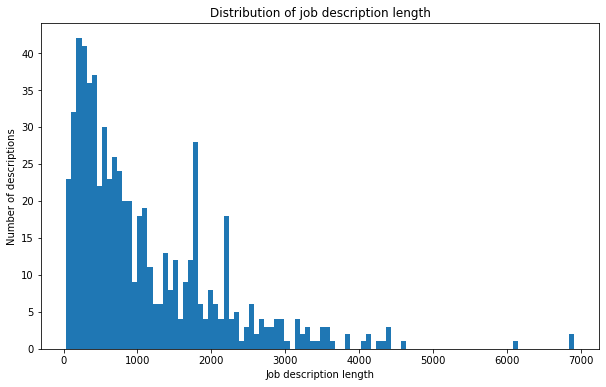

In [333]:
plt.figure(figsize=(10,6))

FBH_Job_size = [len(x) for x in FBH_Job_Data['final cleaned posting text']]
plt.hist(Education_Data_size, bins=100)
plt.title('Distribution of job description length')
plt.ylabel('Number of descriptions')
plt.xlabel('Job description length')
plt.show()

In [334]:
#Transforming data to prepare for the input to lda model

lemmatized_description_lol_fbh = list(FBH_Job_Data['lemmatized description'])
#Dictionary
id2word = corpora.Dictionary(lemmatized_description_lol_fbh)
texts = lemmatized_description_lol_fbh
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1)]]


In [335]:
#Building a baseline LDA model : starting with 8 topics for now

lda_model = LdaModel(corpus=corpus,
                     id2word=id2word,
                     num_topics=8, 
                     random_state=100,
                     chunksize=100,
                     passes=20)

In [336]:
#Top 10 words for each topic

for idx, topic in lda_model.print_topics():
   print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.011*"management" + 0.011*"manager" + 0.009*"work" + 0.008*"must" + 0.008*"employee" + 0.007*"experience" + 0.007*"event" + 0.007*"skill" + 0.007*"staff" + 0.007*"service"
Topic: 1 
Words: 0.023*"experience" + 0.021*"please" + 0.021*"time" + 0.020*"looking" + 0.016*"cook" + 0.015*"must" + 0.015*"resume" + 0.015*"hiring" + 0.014*"position" + 0.013*"restaurant"
Topic: 2 
Words: 0.020*"guest" + 0.014*"restaurant" + 0.013*"move" + 0.012*"including" + 0.011*"team" + 0.011*"effectively" + 0.011*"follow" + 0.010*"work" + 0.009*"procedure" + 0.009*"pound"
Topic: 3 
Words: 0.023*"food" + 0.014*"work" + 0.014*"service" + 0.013*"team" + 0.012*"guest" + 0.011*"restaurant" + 0.011*"kitchen" + 0.011*"customer" + 0.010*"experience" + 0.008*"ability"
Topic: 4 
Words: 0.017*"work" + 0.016*"team" + 0.012*"pay" + 0.011*"hour" + 0.011*"benefit" + 0.011*"looking" + 0.011*"opportunity" + 0.010*"time" + 0.010*"u" + 0.010*"great"
Topic: 5 
Words: 0.040*"driver" + 0.023*"delivery" + 0.016*"ve

In [337]:
lda_top10_data = lda_model.print_topics(10, num_words=5)[:10]

In [339]:
train_vecs = []
for i in range(len(FBH_Job_Data)):
    top_topics = (
        lda_model.get_document_topics(corpus[i],
                                      minimum_probability=0.0))
    topic_vec = [top_topics[i][1] for i in range(7)]
    train_vecs.append(topic_vec)

In [340]:
index_list = []
for i in train_vecs:
    ind = np.argmax(i)
    index_list.append(ind)

In [341]:
overall_topics = []
overall_missed_words = []
for i in range(len(FBH_Job_Data['final cleaned posting text'])):
    try:
        missing_words = []
        print(FBH_Job_Data['final cleaned posting text'][i])
        print('The recommended topic is ', lda_model.print_topics(10, num_words=10)[:10][index_list[i]])
        for j in re.findall(r'"([^"]*)"',lda_top10_data[index_list[i]][1]):
            if j not in list(FBH_Job_Data['lemmatized description'][i]):
                print(j, 'is not in the review despite being in the top recommended topic, do you want to reconsider?')
                missing_words.append(j)
        overall_topics.append(lda_model.print_topics(10, num_words=10)[:10][index_list[i]])
        overall_missed_words.append(missing_words)
    except:
        overall_topics.append('None')
        overall_missed_words.append('None')
        continue
FBH_Job_Data['Topics_assigned'] = overall_topics
FBH_Job_Data['Missing_words'] =  overall_missed_words

need experienced prep cook need cook afternoon evening event
The recommended topic is  (1, '0.023*"experience" + 0.021*"please" + 0.021*"time" + 0.020*"looking" + 0.016*"cook" + 0.015*"must" + 0.015*"resume" + 0.015*"hiring" + 0.014*"position" + 0.013*"restaurant"')
experience is not in the review despite being in the top recommended topic, do you want to reconsider?
please is not in the review despite being in the top recommended topic, do you want to reconsider?
time is not in the review despite being in the top recommended topic, do you want to reconsider?
looking is not in the review despite being in the top recommended topic, do you want to reconsider?
salary chartwells goal make sure student leave cafeteria happier healthier came serving food kid love eat creating custom dining program associate school ranging large public institution small charter private school chartwells built decade food education operational experience driven top culinary nutrition wellness sustainability ta

In [350]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    list1 = []
    
    for i,r in df.iterrows():
        list1.append(format(i))
        list1.append([labels[t] for t in np.argsort(r)[-n_terms:]])
    return(list1)
    
        
Cluster_info = get_top_keywords(Tfidf_FBH, clusters_FBH, vectorizer2.get_feature_names(), 10)

In [351]:
Cluster_data = []
for i,j in enumerate(Cluster_info):
    if i%2==0:
        continue
    else:
        Cluster_data.append(j)

In [353]:
overall_missed_words = []
for i in range(len(FBH_Job_Data['final cleaned posting text'])):
    try:
        missing_words = []
        print(FBH_Job_Data['final cleaned posting text'][i])
        print('The recommended cluster is ',FBH_Job_Data['Clusters'][i], Cluster_data[int(FBH_Job_Data['Clusters'][i])])
        for j in Cluster_data[int(FBH_Job_Data['Clusters'][i])]:
            if j not in list(FBH_Job_Data['lemmatized description'][i]):
                print(j, 'is not in the review despite being in the top recommended topic, do you want to reconsider?')
                missing_words.append(j)
        overall_missed_words.append(missing_words)
    except:
        overall_topics.append('None')
        overall_missed_words.append('None')
        continue
FBH_Job_Data['Missing_words_cluster'] =  overall_missed_words

need experienced prep cook need cook afternoon evening event
The recommended cluster is  8 ['looking', 'please', 'part', 'full time', 'part time', 'full', 'line cook', 'time', 'line', 'cook']
looking is not in the review despite being in the top recommended topic, do you want to reconsider?
please is not in the review despite being in the top recommended topic, do you want to reconsider?
part is not in the review despite being in the top recommended topic, do you want to reconsider?
full time is not in the review despite being in the top recommended topic, do you want to reconsider?
part time is not in the review despite being in the top recommended topic, do you want to reconsider?
full is not in the review despite being in the top recommended topic, do you want to reconsider?
line cook is not in the review despite being in the top recommended topic, do you want to reconsider?
time is not in the review despite being in the top recommended topic, do you want to reconsider?
line is not 

In [354]:
FBH_Job_Data.head()

Link  \
0  https://stlouis.craigslist.org/fbh/d/saint-lou...   
1  https://chicago.craigslist.org/chc/fbh/d/india...   
2  https://lansing.craigslist.org/fbh/d/bath-shop...   
3  https://bn.craigslist.org/fbh/d/south-bend-exe...   
4  https://stlouis.craigslist.org/fbh/d/chesterfi...   

                                       Posting Title Location Category  \
0                               prep and event cooks  stlouis      fbh   
1  director, dining services - k12 - pike townshi...  chicago      fbh   
2          shop and deliver - no experience required  lansing      fbh   
3  executive chef - k12 - career academy - south ...       bn      fbh   
4  resident district manager - k12 - parkway scho...  stlouis      fbh   

                                        Posting Text  \
0  qr code link to this post   need of experience...   
1  qr code link to this post   salary:   chartwel...   
2  qr code link to this post      shop and delive...   
3  qr code link to this post   salary:   chartwel...   
4  qr code link to this post   salary:   chartwel...   

                               tokenized description  \
0  [qr, code, link, to, this, post, need, of, exp...   
1  [qr, code, link, to, this, post, salary, :, ch...   
2  [qr, code, link, to, this, post, shop, and, de...   
3  [qr, code, link, to, this, post, salary, :, ch...   
4  [qr, code, link, to, this, post, salary, :, ch...   

                                 cleaned description  \
0  [qr, code, link, to, this, post, need, of, exp...   
1  [qr, code, link, to, this, post, salary, , cha...   
2  [qr, code, link, to, this, post, shop, and, de...   
3  [qr, code, link, to, this, post, salary, , cha...   
4  [qr, code, link, to, this, post, salary, , cha...   

                      stop_words_removed description  \
0  [need, experienced, prep, cooks, need, cooks, ...   
1  [salary, chartwells, goal, make, sure, student...   
2  [shop, deliver, flexible, schedule, earn, addi...   
3  [salary, chartwells, goal, make, sure, student...   
4  [salary, chartwells, goal, make, sure, student...   

                   single_letter_removed_description  \
0  [need, experienced, prep, cooks, need, cooks, ...   
1  [salary, chartwells, goal, make, sure, student...   
2  [shop, deliver, flexible, schedule, earn, addi...   
3  [salary, chartwells, goal, make, sure, student...   
4  [salary, chartwells, goal, make, sure, student...   

                              lemmatized description  \
0  [need, experienced, prep, cook, need, cook, af...   
1  [salary, chartwells, goal, make, sure, student...   
2  [shop, deliver, flexible, schedule, earn, addi...   
3  [salary, chartwells, goal, make, sure, student...   
4  [salary, chartwells, goal, make, sure, student...   

                          final cleaned posting text  Clusters  \
0  need experienced prep cook need cook afternoon...         8   
1  salary chartwells goal make sure student leave...         9   
2  shop deliver flexible schedule earn additional...         4   
3  salary chartwells goal make sure student leave...         9   
4  salary chartwells goal make sure student leave...         9   

                                     Topics_assigned  \
0  (1, 0.023*"experience" + 0.021*"please" + 0.02...   
1  (0, 0.011*"management" + 0.011*"manager" + 0.0...   
2  (5, 0.040*"driver" + 0.023*"delivery" + 0.016*...   
3  (0, 0.011*"management" + 0.011*"manager" + 0.0...   
4  (0, 0.011*"management" + 0.011*"manager" + 0.0...   

                         Missing_words  \
0  [experience, please, time, looking]   
1                           [employee]   
2                              [valid]   
3                  [manager, employee]   
4                                   []   

                               Missing_words_cluster  
0  [looking, please, part, full time, part time, ...  
1            [texas roadhouse, roadhouse, legendary]  
2  [valid, driver license, license, car, delivery...  
3            [texas roadhouse, roadho

In [357]:
FBH_Job_Data.rename(columns = {'Missing_words':'Missing_words_topic_modelling'}, inplace=True)

In [368]:
FBH_Job_Data['Missing_words_both'] = [set(a) & set(b) for a,b in zip(FBH_Job_Data['Missing_words_topic_modelling'],FBH_Job_Data['Missing_words_cluster'])]

In [370]:
FBH_Job_Data.head()

Link  \
0  https://stlouis.craigslist.org/fbh/d/saint-lou...   
1  https://chicago.craigslist.org/chc/fbh/d/india...   
2  https://lansing.craigslist.org/fbh/d/bath-shop...   
3  https://bn.craigslist.org/fbh/d/south-bend-exe...   
4  https://stlouis.craigslist.org/fbh/d/chesterfi...   

                                       Posting Title Location Category  \
0                               prep and event cooks  stlouis      fbh   
1  director, dining services - k12 - pike townshi...  chicago      fbh   
2          shop and deliver - no experience required  lansing      fbh   
3  executive chef - k12 - career academy - south ...       bn      fbh   
4  resident district manager - k12 - parkway scho...  stlouis      fbh   

                                        Posting Text  \
0  qr code link to this post   need of experience...   
1  qr code link to this post   salary:   chartwel...   
2  qr code link to this post      shop and delive...   
3  qr code link to this post   salary:   chartwel...   
4  qr code link to this post   salary:   chartwel...   

                               tokenized description  \
0  [qr, code, link, to, this, post, need, of, exp...   
1  [qr, code, link, to, this, post, salary, :, ch...   
2  [qr, code, link, to, this, post, shop, and, de...   
3  [qr, code, link, to, this, post, salary, :, ch...   
4  [qr, code, link, to, this, post, salary, :, ch...   

                                 cleaned description  \
0  [qr, code, link, to, this, post, need, of, exp...   
1  [qr, code, link, to, this, post, salary, , cha...   
2  [qr, code, link, to, this, post, shop, and, de...   
3  [qr, code, link, to, this, post, salary, , cha...   
4  [qr, code, link, to, this, post, salary, , cha...   

                      stop_words_removed description  \
0  [need, experienced, prep, cooks, need, cooks, ...   
1  [salary, chartwells, goal, make, sure, student...   
2  [shop, deliver, flexible, schedule, earn, addi...   
3  [salary, chartwells, goal, make, sure, student...   
4  [salary, chartwells, goal, make, sure, student...   

                   single_letter_removed_description  \
0  [need, experienced, prep, cooks, need, cooks, ...   
1  [salary, chartwells, goal, make, sure, student...   
2  [shop, deliver, flexible, schedule, earn, addi...   
3  [salary, chartwells, goal, make, sure, student...   
4  [salary, chartwells, goal, make, sure, student...   

                              lemmatized description  \
0  [need, experienced, prep, cook, need, cook, af...   
1  [salary, chartwells, goal, make, sure, student...   
2  [shop, deliver, flexible, schedule, earn, addi...   
3  [salary, chartwells, goal, make, sure, student...   
4  [salary, chartwells, goal, make, sure, student...   

                          final cleaned posting text  Clusters  \
0  need experienced prep cook need cook afternoon...         8   
1  salary chartwells goal make sure student leave...         9   
2  shop deliver flexible schedule earn additional...         4   
3  salary chartwells goal make sure student leave...         9   
4  salary chartwells goal make sure student leave...         9   

                                     Topics_assigned  \
0  (1, 0.023*"experience" + 0.021*"please" + 0.02...   
1  (0, 0.011*"management" + 0.011*"manager" + 0.0...   
2  (5, 0.040*"driver" + 0.023*"delivery" + 0.016*...   
3  (0, 0.011*"management" + 0.011*"manager" + 0.0...   
4  (0, 0.011*"management" + 0.011*"manager" + 0.0...   

         Missing_words_topic_modelling  \
0  [experience, please, time, looking]   
1                           [employee]   
2                              [valid]   
3                  [manager, employee]   
4                                   []   

                               Missing_words_cluster       Missing_words_both  
0  [looking, please, part, full time, part time, ...  {please, looking, time}  
1            [texas roadhouse, roadhouse, legendary]                       {}  
2  [valid, driver